<a href="https://colab.research.google.com/github/pramodith/llm_exploration/blob/bert_sparse_attention_training/bert_sparse_attention_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the affects of custom Sparse Attention
In our prior notebook, we found that both encoder-only and decoder-only models offload a significant portion of their attention scores to **sink tokens**. We identified that these sink tokens tend to be either special tokens like **[CLS], [SEP]** or tokens corresponding to **punctuations**. The consistence display of this phenomenon across model architectures and inputs makes one question the relevance of dense self-attention.

In this notebook we'll explore the performance of BERT by creating custom attention masks, which will be sparse in nature. We'll create a unique mask per each token, where all tokens attend to special tokens and the k tokens in their neighborhood. When visualized the tokens along a diagonal of size 2*k+1 and the first anad last tokens (in the case of BERT) being attended to. We'll also explore the effects of allowing dense attention in some layers and sparse attention in the rest.

We'll assess the downstream performance of the models that leverage this type of custom attention mask on some commonly used datasets for benchmarking like [TBD].

In [1]:
%pip install transformers
%pip install datasets
%pip install accelerate -U
%pip install scikit-learn
%pip install overrides
%pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


In [72]:
# Importing libraries
from functools import partial
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling
from datasets import load_dataset, load_metric, load_from_disk, Dataset, Metric
from transformers import TrainingArguments, Trainer,logging
from evaluate import load
import torch

from transformers import BertModel, BertForSequenceClassification, BertForMaskedLM
from transformers.data.data_collator import _torch_collate_batch
from transformers.models.bert.modeling_bert import BertEncoder, logger
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions, BaseModelOutputWithPoolingAndCrossAttentions
from transformers.modeling_utils import ModuleUtilsMixin, warnings
from typing import Any, Dict, Optional, Tuple, Union, List, Mapping
from overrides import overrides
from torch import Tensor
from torch.nn.functional import pad
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict


In [3]:
# Defining the model, tokenizer and dataset
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
sample_text = "Every night I lie in bed."

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Get Dataset Splits and Metrics to Evaluate Model Performance


In [29]:
def get_dataset(dataset_name: str, subset_name: Optional[str]) -> Tuple[Dataset, Dataset, Dataset, Metric]:
    """
    This function loads the dataset and metric for the given task name.
    It also splits the dataset into train, dev and test sets.

    Args:
        glue_task_name (str): The name of the task to be loaded.

    Returns:
        Tuple[Dataset, Dataset, Dataset, int]: The train, dev and test datasets.
    """

    # Load the dataset and metric
    dataset = load_dataset(dataset_name, subset_name)
    # Split the dataset
    train_dataset = dataset["train"]
    if "validation" not in dataset or "test" not in dataset:
        split = train_dataset.train_test_split(test_size=0.1)
        if "validation" not in dataset:
            dev_dataset = split["test"]
            test_dataset = dataset["test"]
        elif "test" not in dataset:
            dev_dataset = dataset["validation"]
            test_dataset = split["test"]
    else:
        print(f"{dataset_name} has already been split into train, dev and test sets.")
        dev_dataset = dataset['validation']
        test_dataset = dataset['test']

    # Print a description of the dataset
    print("Dataset Description: ", train_dataset.description)

    # Truncate the dataset if it is too large
    if train_dataset.num_rows > 30000:
        train_dataset = train_dataset.select(range(30000))

    # Print the label space
    print("Label Space: ", train_dataset.features["label"].names)
    num_labels = len(train_dataset.features["label"].names)
    return train_dataset, dev_dataset, test_dataset, num_labels

In [33]:
metrics = [load('accuracy'), load("f1"), load("precision"), load("recall")]
dataset_names = [("dair-ai/emotion",""),("ag_news",""),("tweet_eval","offensive")]
train_datasets, dev_datasets, test_datasets, num_labels, train_datasets_size = [], [], [], [], []
for dataset_name, subset_name in dataset_names:
    train_dataset, dev_dataset, test_dataset, num_label = get_dataset(dataset_name, subset_name)
    train_datasets.append(train_dataset)
    dev_datasets.append(dev_dataset)
    test_datasets.append(test_dataset)
    num_labels.append(num_label)
    train_datasets_size.append(train_dataset.num_rows)

dair-ai/emotion has already been split into train, dev and test sets.
Dataset Description:  Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper.

Label Space:  ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Dataset Description:  AG is a collection of more than 1 million news articles. News articles have been
gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
activity. ComeToMyHead is an academic news search engine which has been running
since July, 2004. The dataset is provided by the academic comunity for research
purposes in data mining (clustering, classification, etc), information retrieval
(ranking, search, etc), xml, data compression, data streaming, and any other
non-commercial activity. For more information, please refer to the link
http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic 

In [7]:
def compute_metrics(eval_pred: Tuple) -> Dict:
    """
    This function computes the metrics for the given task and is used by the Trainer class for evaluation.
    """
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    results = {}
    for metric in metrics:
      if metric.name != "accuracy":
        results.update(metric.compute(predictions=predictions, references=labels, average="macro"))
      else:
        results.update(metric.compute(predictions=predictions, references=labels))
    return results

## Create Custom Bert Model to support 4-D attention masks
HF doesn't support custom layerwise attention masks. By default it assumes that all layers use the same attention mask. However,we want to be able to experiment with using sparse attention in all the layers but also a hybrid of dense and sparse self attention split across layers.

In order to support this functionality we'll need to override some functions and create Custom Bert Models.

First we'll override the `forward` function of `BertEncoder` to accept 5-d attention masks. The 5-d mask corresponds to (Layer, Batch Size, Attention Head, Sequence length (from token), Sequence length (to token)). We assume that all attention heads share the same attention mask in this notebook.


In [8]:
class CustomBertEncoder(BertEncoder):
    def __init__(self, config):
        super().__init__(config)

    @overrides
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        attention_mask_is_layerwise = False

        # Code added here
        if attention_mask.dim() == 5:
            attention_mask_is_layerwise = True

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            # Code added here
            if attention_mask_is_layerwise:
               attention_mask_to_use = attention_mask[i]
            else:
                attention_mask_to_use = attention_mask

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__,
                    hidden_states,
                    attention_mask_to_use,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask_to_use,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


Next we'll override `get_extended_attention_mask` of the `BertModel` class to create a new dimension expanding 4-d attention masks to 5-d attention masks. The expanded dimension corresponds to attention heads as mentioned above since we assume that all attention heads use the same mask we just need to add a new dimension to the mask tensor.

In [9]:
class CustomBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = CustomBertEncoder(config)

    @overrides
    def get_extended_attention_mask(
        self, attention_mask: Tensor, input_shape: Tuple[int], device: torch.device = None, dtype: torch.float = None
    ) -> Tensor:
        """
        Makes broadcastable attention and causal masks so that future and masked tokens are ignored.

        Arguments:
            attention_mask (`torch.Tensor`):
                Mask with ones indicating tokens to attend to, zeros for tokens to ignore.
            input_shape (`Tuple[int]`):
                The shape of the input to the model.

        Returns:
            `torch.Tensor` The extended attention mask, with a the same dtype as `attention_mask.dtype`.
        """
        if dtype is None:
            dtype = self.dtype

        if not (attention_mask.dim() == 2 and self.config.is_decoder):
            # show warning only if it won't be shown in `create_extended_attention_mask_for_decoder`
            if device is not None:
                warnings.warn(
                    "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
                )
        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        # Code added here
        if attention_mask.dim() == 4:
            extended_attention_mask = attention_mask[:, :, None, :, :]
        elif attention_mask.dim() == 3:
            extended_attention_mask = attention_mask[:, None, :, :]
        elif attention_mask.dim() == 2:
            # Provided a padding mask of dimensions [batch_size, seq_length]
            # - if the model is a decoder, apply a causal mask in addition to the padding mask
            # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
            if self.config.is_decoder:
                extended_attention_mask = ModuleUtilsMixin.create_extended_attention_mask_for_decoder(
                    input_shape, attention_mask, device
                )
            else:
                extended_attention_mask = attention_mask[:, None, None, :]
        else:
            raise ValueError(
                f"Wrong shape for input_ids (shape {input_shape}) or attention_mask (shape {attention_mask.shape})"
            )

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and the dtype's smallest value for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(dtype).min
        return extended_attention_mask

    """
    @overrides
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:
        r
        encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            self.warn_if_padding_and_no_attention_mask(input_ids, attention_mask)
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )
    """

#### Create a custom bert model for sequence classification that uses the custom bert encoder

In [10]:
class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.bert = CustomBertModel(config)

In [11]:
def torch_mask_tokens(tokenizer: AutoTokenizer, mlm_probability: float, inputs: Any, special_tokens_mask: Optional[Any] = None) -> Tuple[Any, Any]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """
    import torch

    labels = inputs.clone()
    # We sample a few tokens in each sequence for MLM training (with probability `self.mlm_probability`)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    if special_tokens_mask is None:
        special_tokens_mask = [
            tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
        ]
        special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
    else:
        special_tokens_mask = special_tokens_mask.bool()

    probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

The `custom_tokenize` function tokenizes a given text and creates a custom attention mask for the BERT model.

The function takes four arguments: a tokenizer, a text string, a distance integer (default is 2), and a batch_mode boolean (default is False).

The function tokenizes the text and creates an attention mask with ones on the main diagonal. It then updates the attention mask based on the specified neighborhood distance. The function ensures that the first and last tokens (usually the CLS and SEP tokens in BERT) always attend to all other tokens and are attended to by all other tokens.

If `batch_mode` is `True`, the function adds an extra dimension to the attention mask, input ids, and token type ids to accommodate batch processing.

The function returns a dictionary containing the tokenized input ids, token type ids, and the custom attention mask.

In [12]:
def custom_tokenize(tokenizer: AutoTokenizer, text: str, distance:int=2, batch_mode=False) -> Dict:
    """
    This function tokenizes the given text and returns the tokenized inputs along with the attention mask.

    Args:
        tokenizer (AutoTokenizer): The tokenizer to be used for tokenization.
        text (str): The text to be tokenized.
        distance (int, optional): The number of neigbhoring tokens that should be attended to.
        batch_mode (bool, optional): If we need to add an extra dimension for batch processing.

    Returns:
        Dict: The tokenized inputs along with the attention mask.
    """
    # Tokenize the texts
    result = tokenizer(text, truncation=True, padding=False)
    # Create attention mask with ones on the main diagonal
    attention_mask = torch.eye(len(result["input_ids"]), dtype=torch.long)
    # Update attention mask for the specified neighborhood distance
    attention_mask[abs(torch.arange(len(attention_mask))[:, None] - torch.arange(len(attention_mask))) <= distance] = 1

    # Set the first row to 1 corresponding to the CLS token
    attention_mask[0, :] = 1
    # Always attend to CLS
    attention_mask[:, 0] = 1
    # Set the last row to 1 corresponding to the SEP token
    attention_mask[-1, :] = 1
    # Always attend to SEP
    attention_mask[:, -1] = 1
    # Add the attention mask to the result

    if batch_mode:
      result["attention_mask"] = torch.LongTensor(attention_mask.unsqueeze(0))
      result["input_ids"] = torch.LongTensor(result["input_ids"]).unsqueeze(0)
      result["token_type_ids"] = torch.LongTensor(result["token_type_ids"]).unsqueeze(0)
    else:
      result["attention_mask"] = torch.LongTensor(attention_mask)
      result["input_ids"] = torch.LongTensor(result["input_ids"])
      result["token_type_ids"] = torch.LongTensor(result["token_type_ids"])
    # Map the labels to the tokenized inputs
    return result

Let's make sure our implementation is right by visualizing a heatmap of our attention scores. We should expect to see a sliding window of attention along the diagonal while the **[CLS]** and **[SEP]** tokens are allowed to attend to all tokens and all tokens are allowed to attend to the **[CLS]** and **[SEP]** tokens.

In [13]:
custom_model = CustomBertForSequenceClassification.from_pretrained(model_name)
inputs = custom_tokenize(tokenizer, sample_text, distance=1, batch_mode=True)
output = custom_model(**inputs, output_attentions=True)

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


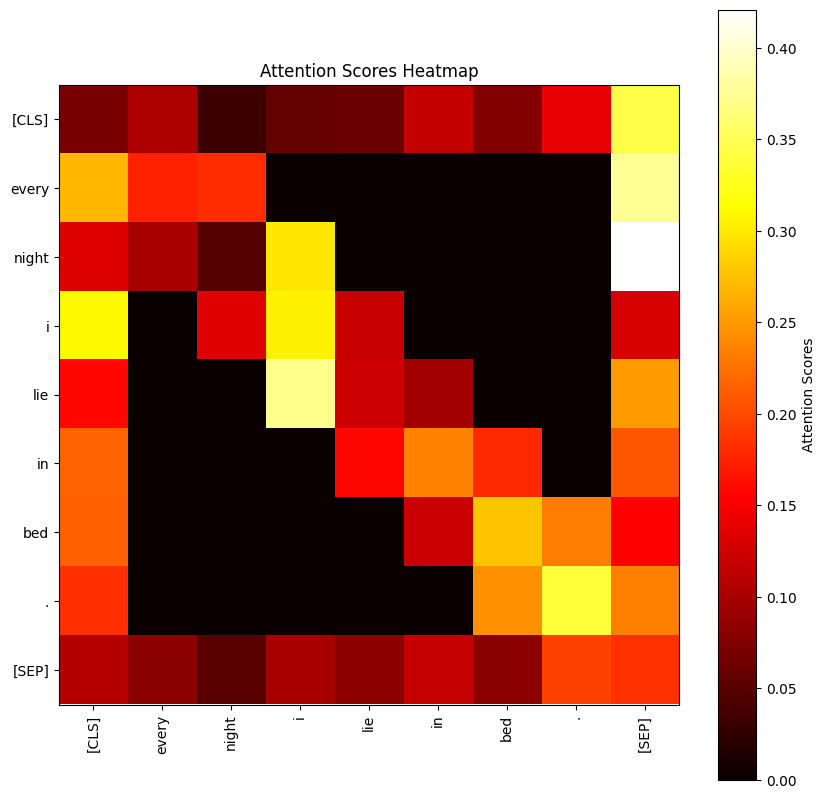

In [14]:
import matplotlib.pyplot as plt

# Get the attention scores for Layer 0, Batch 0, Head 0
attention_scores = output.attentions[0][0,0].detach().numpy()

# Get the tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Create a heatmap
plt.figure(figsize=(10,10))
plt.imshow(attention_scores, cmap='hot', interpolation='nearest')
plt.colorbar(label='Attention Scores')
plt.title('Attention Scores Heatmap')
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.show()

In [15]:
inputs["attention_mask"].shape

torch.Size([1, 9, 9])

Great! That's working, now let's make sure that masking also works when we send in a 4-d tensor. Where dimension 0 is the layer number.

In [16]:
inputs["attention_mask"] = inputs["attention_mask"].unsqueeze(0).repeat(12,1,1,1)
output_layerwise_mask = custom_model(**inputs, output_attentions=True)
assert torch.allclose(output.attentions[0], output_layerwise_mask.attentions[0]), "Attention scores have to be the same for the same attention mask even if it is repeated layerwise"

## Creating Layerwise Attention Masks
The `get_layerwise_attention_mask` function is designed to create a layer-wise attention mask from a given input attention mask. This function is particularly useful when working with transformer models like BERT, where different layers might require different attention masks.

Here are the parameters of the function:

- `attention_mask` (Tensor): This is the input attention mask that you want to convert into a layer-wise attention mask. It should be a tensor.

- `pad_token_pos` (int): This is the position of the padding token in the attention mask. The function uses this to set the range of full attention.

- `total_num_layers` (int, optional): This is the total number of layers in the model. By default, it's set to 12, which is the number of layers in BERT-base models.

- `full_attention_layers` (list, optional): This is a list of layer numbers that should have full attention. By default, it's an empty list, meaning no layers have full attention.

The function returns a tensor which is the layer-wise attention mask. If `full_attention_layers` is not empty, the function repeats the attention mask for each layer and sets full attention for the specified layers.

In [17]:
def get_layerwise_attention_mask(attention_mask: Tensor, pad_token_pos:int, total_num_layers:int=12, full_attention_layers=[]):
  """
  Returns a layer-wise attention mask for a given input attention mask.

  Args:
    attention_mask (Tensor): The input attention mask.
    pad_token_pos (int): The position of the padding token in the attention mask.
    total_num_layers (int, optional): The total number of layers in the model. Defaults to 12.
    full_attention_layers (list, optional): A list of layer numbers that should have full attention. Defaults to [].

  Returns:
    Tensor: The layer-wise attention mask.
  """
  attention_mask = attention_mask.unsqueeze(0)
  if full_attention_layers:
    attention_mask = attention_mask.repeat(total_num_layers, 1, 1, 1)
    for layer_num in full_attention_layers:
      attention_mask[layer_num, :, : pad_token_pos, : pad_token_pos] = 1
  return attention_mask

Let's make sure that this is working as desired.
This test case is validating the `get_layerwise_attention_mask` function. It checks three things:

1. The function returns an attention mask of the correct shape (12, 1, 4, 4).
2. The attention mask at layer 0 is the same as the input mask (all zeros).
3. The attention mask at layer 2 is all ones, indicating full attention.

If any of these conditions are not met, the test case fails.

In [18]:
dummy_attn_mask = torch.zeros(1, 4, 4)
layerwise_attn_mask = get_layerwise_attention_mask(dummy_attn_mask, 4, full_attention_layers=[2])
assert layerwise_attn_mask.shape == (12, 1, 4, 4), f"{layerwise_attn_mask.shape} is the wrong shape"
assert torch.allclose(layerwise_attn_mask[0], dummy_attn_mask), "Masks at layer 0 should all be 0s"
assert torch.allclose(layerwise_attn_mask[2], torch.ones(1,4,4)), "Masks at layer 1 should all be 1s"

## Padding custom attention Masks

The `custom_collate` function is a utility function designed to process a batch of data for training a transformer model like BERT. It performs several key tasks:

1. **Padding**: It pads all sequences in the batch to the same length, using the provided `pad_token_id`.

2. **Layer-wise Attention Mask**: It creates a layer-wise attention mask for each sequence in the batch. This is useful when different layers of the transformer model require different attention masks.

3. **Masked Language Modeling**: If the `is_mlm` flag is set to `True`, it applies masked language modeling to the input sequences. This involves randomly masking some of the tokens in each sequence, with the goal of predicting the original token from its context. The probability of masking a token is controlled by the `mlm_probability` parameter.

The function returns a dictionary containing the padded 'input_ids', the layer-wise 'attention_mask', 'token_type_ids', and 'labels' (if present in the batch).

In [19]:
def custom_collate(batch:List, pad_token_id:int, full_attention_layers:List=[], mlm_probability:float=0.15, is_mlm:bool=False):
  """
  Custom collate function for DataLoader that pads sequences and creates layer-wise attention masks.

  Args:
    batch (list): List of dictionaries containing 'input_ids', 'attention_mask', 'token_type_ids', and optionally 'label'.
    pad_token_id (int): The ID of the padding token.
    full_attention_layers (list, optional): List of layers that should have full attention. Defaults to [].
    mlm_probability (float, optional): Probability of masking a token for masked language modeling. Defaults to 0.15.
    is_mlm (bool, optional): Whether to apply masked language modeling. Defaults to False.

  Returns:
    dict: A dictionary containing 'input_ids', 'attention_mask', 'token_type_ids', and 'labels' (if present in batch).
  """
  input_ids = [torch.LongTensor(batch[i]["input_ids"]) for i in range(len(batch))]
  attention_mask = [torch.LongTensor(batch[i]["attention_mask"]) for i in range(len(batch))]
  token_type_ids = [torch.LongTensor(batch[i]["token_type_ids"]) for i in range(len(batch))]
  if "label" in batch[0]:
    label = torch.LongTensor([batch[i]["label"] for i in range(len(batch))])
  #idx = [batch[i]["idx"] for i in range(len(batch))]
  max_len = max([len(inp) for inp in input_ids])
  padding_sizes = [max_len - len(inp) for inp in input_ids]
  input_ids = pad_sequence(input_ids, batch_first=True, padding_value=pad_token_id)
  token_type_ids = pad_sequence(token_type_ids, batch_first=True)
  attention_mask = [get_layerwise_attention_mask(pad(attention_mask[i], (0, padding_sizes[i], 0, padding_sizes[i]), value=0), padding_sizes[i], full_attention_layers=full_attention_layers).squeeze(1) for i in range(len(batch))]
  attention_mask = torch.stack(attention_mask)
  if full_attention_layers:
    attention_mask = attention_mask.permute(1,0,2,3)
  else:
    attention_mask = attention_mask.squeeze(1)

  if is_mlm:
    input_ids, label = torch_mask_tokens(tokenizer, mlm_probability, input_ids)
  return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "token_type_ids": token_type_ids,
      "labels": label,
  }

In [20]:
custom_collate([{"input_ids":[1,2,3,4], "attention_mask":[[1,1,1,0],[1,1,1,0],[1,1,1,0],[1,1,1,0]], "token_type_ids":[0,0,0,0], "label":1}, {"input_ids":[1,2,3,4,5], "attention_mask":[[1,1,1,0,0],[1,1,1,0,0],[1,1,1,0,0],[1,1,1,0,0],[1,1,1,0,0]], "token_type_ids":[0,0,0,0,0], "label":1}], tokenizer.pad_token_id, full_attention_layers=[2,4], is_mlm=True)

{'input_ids': tensor([[  1,   2,   3,   4,   0],
         [  1,   2, 103,   4, 103]]),
 'attention_mask': tensor([[[[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [0, 0, 0, 0, 0]],
 
          [[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0]]],
 
 
         [[[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [0, 0, 0, 0, 0]],
 
          [[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0]]],
 
 
         [[[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [0, 0, 0, 0, 0]],
 
          [[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0]]],
 
 
         [[[1, 1, 1, 0, 0],


In [21]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 11916
})

We need to encode the datasets for dense and sparse attention differently since we need to create custom attention masks for the latter.

In [64]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, tokenizer, mode="sparse", is_mlm:bool = False):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.mode = mode
        self.is_mlm = is_mlm

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      if self.mode == "sparse":
        return custom_tokenize(self.tokenizer, self.dataset[idx]["text"])
      else:
        inputs = tokenizer(self.dataset[idx]["text"], return_tensors="pt", truncation=True)
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        if not self.is_mlm:
          inputs["labels"] = self.dataset[idx]["label"]
        return inputs

In [65]:
train_datasets_dense_attention, dev_datasets_dense_attention, test_datasets_dense_attention = [], [], []
train_datasets_sparse_attention, dev_datasets_sparse_attention, test_datasets_sparse_attention = [], [], []
for i in range(len(train_datasets)):
    # Encode the datasets that'll leverage dense attention
    train_datasets_dense_attention.append(CustomDataset(train_datasets[i], tokenizer, mode="dense"))
    dev_datasets_dense_attention.append(CustomDataset(dev_datasets[i], tokenizer, mode="dense"))
    test_datasets_dense_attention.append(CustomDataset(test_datasets[i], tokenizer, mode="dense"))

    # Encode the datasets that'll leverage sparse attention
    train_datasets_sparse_attention.append(CustomDataset(train_datasets[i], tokenizer, mode="sparse"))
    dev_datasets_sparse_attention.append(CustomDataset(dev_datasets[i], tokenizer, mode="sparse"))
    test_datasets_sparse_attention.append(CustomDataset(test_datasets[i], tokenizer, mode="sparse"))

In [66]:
train_datasets[1][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

## Training the model with dense attention

In [79]:
logging.set_verbosity_warning()

def train_and_evaluate(
    train_datasets: List[Dataset],
    dev_datasets: List[Dataset],
    test_datasets: List[Dataset],
    tokenizer: AutoTokenizer,
) -> Dict[str, List[Dict]]:
    results = defaultdict(list)
    # Define the training arguments
    for i in range(len(train_datasets)):
        print(f"Training on {dataset_names[i][0]}")
        for j in range(5):
            print(f"Training for the {j}th run.")
            model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels[i])
            training_args = TrainingArguments(
                output_dir='./results',          # output directory
                num_train_epochs=5,            # total number of training steps
                per_device_train_batch_size=64,  # batch size per device during training
                per_device_eval_batch_size=128,   # batch size for evaluation
                warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
                weight_decay=0.01,               # strength of weight decay
                logging_dir='./logs',            # directory for storing logs
                fp16=True,
                seed=j,
                gradient_checkpointing=True,
                evaluation_strategy="steps",
                eval_steps=100,
                load_best_model_at_end=True,
                logging_steps=100,
                save_steps=100,
                use_cpu=False
            )

            # Initialize the trainer
            trainer_dense_attention = Trainer(
                model=model,
                tokenizer=tokenizer,                 # the instantiated 🤗 Transformers model to be trained
                args=training_args,                  # training arguments, defined above
                train_dataset=train_datasets[i],         # training dataset
                eval_dataset=dev_datasets[i],       # evaluation dataset
                data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding=True),
                compute_metrics=compute_metrics
        )
            trainer_dense_attention.train()
            test_results = trainer_dense_attention.evaluate(test_datasets[i])
            print(f"Results on the test set are: {test_results}")
            results[dataset_names[i]].append(test_results)
    return results

In [80]:
dense_attention_results = train_and_evaluate(train_datasets_dense_attention, dev_datasets_dense_attention, test_datasets_dense_attention, tokenizer)

Training on dair-ai/emotion
Training for the 0th run.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.538500,0.987135,0.648000,0.366841,0.425667,0.407204
200,0.495500,0.284090,0.904500,0.875430,0.877149,0.875704
300,0.223300,0.223224,0.920000,0.895005,0.887589,0.907923
400,0.172000,0.164208,0.934000,0.908817,0.916563,0.903184
500,0.152900,0.157160,0.935000,0.908336,0.923005,0.901856
600,0.104300,0.164265,0.938000,0.910310,0.927269,0.898019
700,0.103800,0.149486,0.938500,0.912389,0.915231,0.912348
800,0.090400,0.165205,0.935500,0.908137,0.917250,0.902589
900,0.073400,0.154554,0.938000,0.911917,0.921424,0.903199
1000,0.077000,0.162166,0.933000,0.907245,0.911937,0.903465


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the

Results on the test set are: {'eval_loss': 0.156802698969841, 'eval_accuracy': 0.929, 'eval_f1': 0.8908752356686643, 'eval_precision': 0.8993969870626405, 'eval_recall': 0.8882986324780098, 'eval_runtime': 1.5284, 'eval_samples_per_second': 1308.542, 'eval_steps_per_second': 10.468, 'epoch': 5.0}
Training for the 1th run.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.387300,0.821998,0.743500,0.546292,0.623249,0.549582
200,0.443100,0.247642,0.916500,0.893813,0.912520,0.880752
300,0.212500,0.194212,0.931500,0.903742,0.905216,0.902519
400,0.162200,0.162689,0.938500,0.913272,0.928882,0.902097
500,0.134200,0.142449,0.932000,0.900841,0.924868,0.883651
600,0.099800,0.150007,0.939500,0.917276,0.916333,0.918481
700,0.101300,0.154605,0.932500,0.910274,0.906363,0.917568
800,0.086200,0.157229,0.937500,0.913089,0.916561,0.912004
900,0.075700,0.163726,0.935000,0.910194,0.914577,0.907599
1000,0.074200,0.153595,0.941000,0.915114,0.910537,0.920412


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the

Results on the test set are: {'eval_loss': 0.14336319267749786, 'eval_accuracy': 0.9295, 'eval_f1': 0.8793977697070386, 'eval_precision': 0.9177446042726154, 'eval_recall': 0.8557266072605848, 'eval_runtime': 1.5019, 'eval_samples_per_second': 1331.684, 'eval_steps_per_second': 10.653, 'epoch': 5.0}
Training for the 2th run.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.478100,0.920295,0.705000,0.467987,0.538495,0.489866
200,0.453100,0.254336,0.913500,0.888956,0.876603,0.908898
300,0.208400,0.164501,0.932000,0.905741,0.901306,0.916876
400,0.165100,0.144138,0.941000,0.918671,0.915644,0.922711
500,0.140200,0.149416,0.937000,0.913674,0.908030,0.923106
600,0.099500,0.134670,0.939000,0.913228,0.924696,0.903386
700,0.096500,0.125355,0.941500,0.918545,0.908399,0.931566
800,0.085700,0.137454,0.938500,0.914394,0.926598,0.906771
900,0.071200,0.137831,0.939500,0.916833,0.928594,0.909147
1000,0.071700,0.140389,0.939000,0.914960,0.916106,0.914715


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the

Results on the test set are: {'eval_loss': 0.13654649257659912, 'eval_accuracy': 0.934, 'eval_f1': 0.898604415244582, 'eval_precision': 0.8877829311470348, 'eval_recall': 0.9183891935320584, 'eval_runtime': 1.5131, 'eval_samples_per_second': 1321.76, 'eval_steps_per_second': 10.574, 'epoch': 5.0}
Training for the 3th run.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.469000,0.802894,0.751000,0.576979,0.620659,0.570743
200,0.459600,0.214708,0.927500,0.903419,0.905439,0.904524
300,0.205000,0.175784,0.934000,0.910963,0.917215,0.912385
400,0.167200,0.173686,0.936000,0.911441,0.910754,0.914580
500,0.130100,0.135300,0.940000,0.913958,0.914641,0.914600
600,0.105300,0.135150,0.937500,0.910817,0.928030,0.898736
700,0.101700,0.160110,0.938500,0.911621,0.921320,0.912963
800,0.083400,0.144522,0.936000,0.909892,0.910865,0.911813
900,0.067600,0.161616,0.938500,0.915665,0.918529,0.914210
1000,0.068400,0.148731,0.944000,0.920618,0.919155,0.923799


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the

Results on the test set are: {'eval_loss': 0.13839410245418549, 'eval_accuracy': 0.9385, 'eval_f1': 0.8921853401463893, 'eval_precision': 0.928184877611049, 'eval_recall': 0.8777379254710679, 'eval_runtime': 1.5348, 'eval_samples_per_second': 1303.069, 'eval_steps_per_second': 10.425, 'epoch': 5.0}
Training for the 4th run.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.416400,0.867298,0.717500,0.519587,0.578646,0.515848
200,0.472400,0.249907,0.916500,0.889131,0.878813,0.908643
300,0.205500,0.183970,0.933000,0.906266,0.910734,0.903516
400,0.155700,0.169451,0.932000,0.904866,0.925788,0.889125
500,0.141700,0.150243,0.939000,0.912702,0.951523,0.884872
600,0.100200,0.140218,0.941000,0.914388,0.929709,0.907216
700,0.097800,0.132816,0.943500,0.917200,0.935874,0.903024
800,0.093300,0.126232,0.942000,0.915679,0.908374,0.925166
900,0.075700,0.137944,0.943500,0.918366,0.934112,0.905686
1000,0.073100,0.140400,0.940000,0.915031,0.919460,0.912593


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the

Results on the test set are: {'eval_loss': 0.14238561689853668, 'eval_accuracy': 0.936, 'eval_f1': 0.8947028451021564, 'eval_precision': 0.8902785377173837, 'eval_recall': 0.9050020155977497, 'eval_runtime': 1.5403, 'eval_samples_per_second': 1298.431, 'eval_steps_per_second': 10.387, 'epoch': 5.0}
Training on ag_news
Training for the 0th run.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.261700,0.943628,0.799500,0.797234,0.806602,0.798773
200,0.569700,0.324580,0.899083,0.898691,0.899459,0.898749
300,0.293700,0.279817,0.910083,0.909494,0.909366,0.909814
400,0.276600,0.268053,0.911917,0.911427,0.916023,0.911476
500,0.250100,0.212656,0.928333,0.928089,0.928846,0.928077
600,0.247200,0.211162,0.927583,0.927491,0.928399,0.927495
700,0.238200,0.215983,0.924667,0.925104,0.927784,0.924265
800,0.216700,0.204166,0.932500,0.932484,0.934248,0.932026
900,0.214100,0.201816,0.931167,0.931063,0.931918,0.930811
1000,0.222400,0.184716,0.933917,0.933540,0.935421,0.933838


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

KeyboardInterrupt: ignored

In [81]:
dense_attention_results

NameError: ignored

## Evaluating the trained model

In [ ]:
trainer_dense_attention.evaluate(test_dataset_dense_attention)

{'eval_loss': 0.14260536432266235,
 'eval_accuracy': 0.9305,
 'eval_f1': 0.8869114759799867,
 'eval_precision': 0.8952005188725458,
 'eval_recall': 0.8813286392626377,
 'eval_runtime': 0.779,
 'eval_samples_per_second': 2567.461,
 'eval_steps_per_second': 20.54,
 'epoch': 5.0}

In [ ]:
## Training the model with sparse attention
custom_model = CustomBertForSequenceClassification.from_pretrained(model_name, num_labels=len(train_dataset.features["label"].names))

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_sparse_attention = Trainer(
    model=custom_model,
    tokenizer=tokenizer,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset_sparse_attention,         # training dataset
    eval_dataset=dev_dataset_sparse_attention,           # evaluation dataset
    data_collator=partial(custom_collate, pad_token_id=tokenizer.pad_token_id),
    compute_metrics=compute_metrics
  )

trainer_sparse_attention.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.453700,0.859466,0.697000,0.448461,0.653476,0.469717
200,0.483600,0.297570,0.909500,0.882669,0.878018,0.888713
300,0.248500,0.231922,0.911500,0.877822,0.887640,0.869651
400,0.197700,0.189323,0.928500,0.903730,0.921616,0.893146
500,0.174000,0.170435,0.926500,0.900691,0.911592,0.891724
600,0.113700,0.171035,0.925000,0.893360,0.889176,0.898020
700,0.120300,0.172024,0.927000,0.904048,0.890522,0.921063
800,0.098600,0.166487,0.932000,0.904231,0.899451,0.909561
900,0.081500,0.180832,0.928500,0.903243,0.901719,0.905511
1000,0.076800,0.188413,0.930500,0.903084,0.917928,0.890809


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the

TrainOutput(global_step=1250, training_loss=0.2550808616638184, metrics={'train_runtime': 206.7186, 'train_samples_per_second': 386.999, 'train_steps_per_second': 6.047, 'total_flos': 2323386947729664.0, 'train_loss': 0.2550808616638184, 'epoch': 5.0})

## Evaluating the model

In [ ]:
trainer_sparse_attention.evaluate(test_dataset_sparse_attention)

{'eval_loss': 0.17503787577152252,
 'eval_accuracy': 0.924,
 'eval_f1': 0.881268107518956,
 'eval_precision': 0.8770890771932288,
 'eval_recall': 0.8859999660070658,
 'eval_runtime': 1.5774,
 'eval_samples_per_second': 1267.898,
 'eval_steps_per_second': 10.143,
 'epoch': 5.0}

## Training a model with hybrid dense+sparse attention

In [ ]:
custom_model = CustomBertForSequenceClassification.from_pretrained(model_name, num_labels=len(train_dataset.features["label"].names))
trainer_sparse_layerwise_attention = Trainer(
    model=custom_model,
    tokenizer=tokenizer,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset_sparse_attention,         # training dataset
    eval_dataset=dev_dataset_sparse_attention,           # evaluation dataset
    data_collator=partial(custom_collate, pad_token_id=tokenizer.pad_token_id, full_attention_layers=[0,1,2,3]),
    compute_metrics=compute_metrics
  )

trainer_sparse_layerwise_attention.train()

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.491700,0.867480,0.690000,0.442549,0.594815,0.461187
200,0.489000,0.274168,0.911500,0.882613,0.880070,0.885990
300,0.242000,0.221881,0.921000,0.895113,0.898978,0.895241
400,0.186800,0.184280,0.928500,0.903116,0.916973,0.893337
500,0.172200,0.146533,0.938500,0.913183,0.925667,0.903153
600,0.111600,0.165268,0.932500,0.904286,0.911461,0.900496
700,0.110700,0.147053,0.929000,0.901380,0.907041,0.896373
800,0.092100,0.142600,0.935500,0.910201,0.908313,0.913224
900,0.080300,0.148731,0.930500,0.903956,0.905733,0.903091
1000,0.074800,0.157338,0.934500,0.906104,0.914557,0.899937


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the

TrainOutput(global_step=1250, training_loss=0.2558851728439331, metrics={'train_runtime': 227.2943, 'train_samples_per_second': 351.967, 'train_steps_per_second': 5.499, 'total_flos': 2323386947729664.0, 'train_loss': 0.2558851728439331, 'epoch': 5.0})

In [ ]:
trainer_sparse_layerwise_attention.evaluate(test_dataset_sparse_attention)

{'eval_loss': 0.14260034263134003,
 'eval_accuracy': 0.9355,
 'eval_f1': 0.9102013880474451,
 'eval_precision': 0.9083133101100925,
 'eval_recall': 0.9132236399814221,
 'eval_runtime': 1.8579,
 'eval_samples_per_second': 1076.493,
 'eval_steps_per_second': 8.612,
 'epoch': 5.0}

## BERT Pre-training with Sparse Attention

Let's pre-train a Bert model with sparse attention to validate if pre-training with sparse attention gives a boost to finetuning when using the same strategy rather than solely finetuning with sparse attention.

We'll use the **openwebtext** dataset for pre-training, the original model wasn't pre-trained on this dataset.

In [ ]:
def get_pretraining_dataset(dataset_name):
    ds = load_dataset(dataset_name, split='train', streaming=True)
    return ds.take(136000)

Since the dataset is too large to load into memory, we'll use the streaming API to load a subset of the dataset.

In [ ]:
from functools import partial
from datasets import Dataset

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

In [ ]:
pretraining_train_dataset = get_pretraining_dataset("Skylion007/openwebtext")

Convert an `IterableDataset` to `Dataset`

In [ ]:
pretraining_train_dataset = Dataset.from_generator(partial(gen_from_iterable_dataset, pretraining_train_dataset), features=pretraining_train_dataset.features)

In [ ]:
pretraining_train_dataset = pretraining_train_dataset.train_test_split(test_size=0.1)

In [ ]:
pretraining_dev_dataset = pretraining_train_dataset["test"]
pretraining_train_dataset = pretraining_train_dataset["train"]

### Optional: Save the dataset to memory for faster loading in the future.

In [ ]:
pretraining_train_dataset.save_to_disk("./datasets/pretraining_train")
pretraining_dev_dataset.save_to_disk("./datasets/pretraining_dev")

NameError: ignored

In [ ]:
pretraining_train_dataset = load_from_disk("./datasets/pretraining_train")
pretraining_dev_dataset = load_from_disk("./datasets/pretraining_dev")

In [ ]:
pretraining_train_dataset

Dataset({
    features: ['text'],
    num_rows: 122400
})

In [ ]:
# pretraining_train_dataset = pretraining_train_dataset.map(lambda example: custom_tokenize(tokenizer, example["text"]), batched=False)
# pretraining_dev_dataset = pretraining_dev_dataset.map(lambda example: custom_tokenize(tokenizer, example["text"]), batched=False)


Since the dataset is large we don't want to vectorize all of it into memory as we did for our downstream tasks. We'll create a custom Pytorch Dataset that vectorizes only the required items of the batch into memory.

In [ ]:
pretraining_train_torch_dataset = CustomDataset(pretraining_train_dataset, tokenizer)
pretraining_dev_torch_dataset = CustomDataset(pretraining_dev_dataset, tokenizer)

pretraining_train_torch_dense_dataset = CustomDataset(pretraining_train_dataset, tokenizer, mode="dense")
pretraining_dev_torch_dense_dataset = CustomDataset(pretraining_dev_dataset, tokenizer, mode="dense")


NameError: name 'pretraining_train_dataset' is not defined

We'll continue pre-training the original Bert Model using a Masked Language Modeling head.

In [ ]:
mlm_model = BertForMaskedLM.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer.encode("hello")

[101, 7592, 102]

We'll train for 500 steps.

In [ ]:
pretraining_args = TrainingArguments(
    output_dir='./bert-sparse-sliding-window-attention',          # output directory
    max_steps=500,            # total number of training steps
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    fp16=True,
    #torch_compile=True, # optimizations
    #optim="adamw_torch_fused", # improved optimizer
    gradient_checkpointing=True,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=200,
    load_best_model_at_end=True,
    logging_steps=100,
    eval_accumulation_steps=4,
    gradient_accumulation_steps=4,
    push_to_hub=True
)

pretrainer_dense_attention = Trainer(
    model=mlm_model,
    tokenizer=tokenizer,                 # the instantiated 🤗 Transformers model to be trained
    args=pretraining_args,                  # training arguments, defined above
    train_dataset=pretraining_train_torch_dense_dataset,         # training dataset
    eval_dataset=pretraining_dev_torch_dense_dataset,           # evaluation dataset
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer),
)

Let's examine the loss of the original Bert Model on the dev dataset. Note that this is the model that uses **dense attention**.

In [ ]:
pretrainer_dense_attention.evaluate(pretraining_dev_torch_dense_dataset)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 2.7092370986938477,
 'eval_runtime': 107.939,
 'eval_samples_per_second': 125.997,
 'eval_steps_per_second': 1.973}

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Let's now create a CustomBertModel that uses the CustomBertEncoder that we defined earlier.

In [ ]:
class CustomBertForMaskedLM(BertForMaskedLM):
  def __init__(self, config):
    super().__init__(config)
    self.bert = CustomBertModel(config)

In [ ]:
custom_mlm_model = CustomBertForMaskedLM.from_pretrained(model_name)

In [ ]:
pretrainer_sparse_layerwise_attention = Trainer(
    model=custom_mlm_model,
    tokenizer=tokenizer,                 # the instantiated 🤗 Transformers model to be trained
    args=pretraining_args,                  # training arguments, defined above
    train_dataset=pretraining_train_torch_dataset,         # training dataset
    eval_dataset=pretraining_dev_torch_dataset,           # evaluation dataset
    data_collator = partial(custom_collate, pad_token_id=tokenizer.pad_token_id, is_mlm=True),
)

In [ ]:
print(f"Loss before training : {pretrainer_sparse_layerwise_attention.evaluate(pretraining_dev_torch_dataset)}")

Perplexity before training : {'eval_loss': 4.9193434715271, 'eval_runtime': 119.7049, 'eval_samples_per_second': 113.613, 'eval_steps_per_second': 1.779}


In [ ]:
pretrainer_sparse_layerwise_attention.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
100,3.634400,3.035876
200,3.104800,2.889886
300,3.012300,2.828573
400,2.961000,2.797679
500,2.939900,2.782165


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight',

TrainOutput(global_step=500, training_loss=3.130488464355469, metrics={'train_runtime': 1911.784, 'train_samples_per_second': 33.477, 'train_steps_per_second': 0.262, 'total_flos': 1.6961223131136e+16, 'train_loss': 3.130488464355469, 'epoch': 0.52})

In [ ]:
print(f"Perplexity after training : {pretrainer_sparse_layerwise_attention.evaluate(pretraining_dev_torch_dataset)}")

Perplexity after training : {'eval_loss': 2.8012802600860596, 'eval_runtime': 119.7757, 'eval_samples_per_second': 113.546, 'eval_steps_per_second': 1.778, 'epoch': 0.52}


In [ ]:
!nvidia-smi